In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")

In [4]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)
invalid_subjs = qa_records['invalid']

In [5]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

In [6]:
def load_subj_behav_data(subj):
    behav_data = pd.read_csv(os.path.join(
        DEFAULT_FEATURE_FOLDER, str(subj), 'behavior.csv'), index_col=0)
    return behav_data

In [7]:
RESULTS_PATH = os.path.join(get_n_dir_up(CUR_PATH, 3), 'results')
PLOTS_FOLDER = os.path.join(RESULTS_PATH, 'images', 'behavior', 'behavior_gaze')

## Compare Draw v.s. Click

### convert response to distribution

In [8]:
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

from utils.inverted_encoding import (
    compute_accuracy, compute_bias, deg_signed_diff,
)

In [9]:
from utils.behav_analysis_helper import df_to_errs, errdf_to_distrib

In [10]:
example_df = load_subj_behav_data(908)
example_err_df = df_to_errs(example_df, None)

In [11]:
draw_lmb = lambda df: (df['mode'] == 'draw').to_numpy()
click_lmb = lambda df: (df['mode'] == 'click').to_numpy()

#### plot the err distribution

In [12]:
from utils.inverted_encoding import (
    raw_display_shifted_distrib, 
    deg_signed_diff,
    compute_accuracy
)


def compute_smoothing_weight(sharpness=150):
    # compute weights
    resp = np.arange(180)
    outer_diffs = deg_signed_diff(
        np.subtract.outer(resp, resp))
    outer_sims = np.cos(np.deg2rad(outer_diffs))
    weights = np.exp(outer_sims * sharpness)
    weights = weights / np.sum(weights, axis=1, keepdims=True)
    return weights

SMOOTHING_WEIGHTS = compute_smoothing_weight()

def plot_behav_err_distrib(
        ax, lmb=None, ref_type=None,
        **kwargs):
    
    ref = {
        'target': None,
        'previous': 'prev_resp',
        'nontarget': 'non_target',
    }[ref_type]

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)
        distrib = errdf_to_distrib(err_df, ref=ref)

        if len(distrib) == 0:
            continue

        # apply smoothing
        distrib = np.dot(
            SMOOTHING_WEIGHTS, distrib)

        subj_names.append(int(subj))
        subj_data.append(distrib)

    # plot the result
    distrib = np.array(subj_data)
    subj_series = pd.Series(subj_names)
    raw_display_shifted_distrib(
        ax, distrib, ref_type=ref_type,
        mask=None, subj_series=subj_series,
        ylim_min=-0.0005, ylim_max=0.0305,
        **kwargs)
    
    # also compute the stats
    accs = {}
    for subj, distrib in zip(subj_names, subj_data):
        acc = compute_accuracy(distrib)
        accs[subj] = acc
    return accs

In [13]:
MODE_COLORS = {
    'draw': 'skyblue',
    'click': 'coral',
}

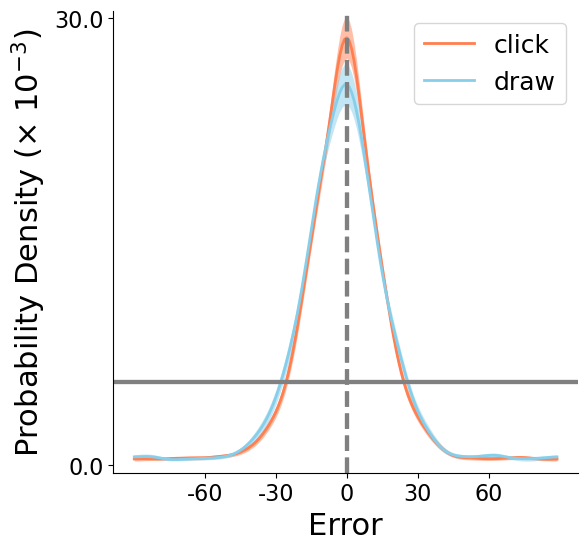

In [14]:
fig, ax = plt.subplots(1, figsize=(6, 6))

click_accs = plot_behav_err_distrib(
    ax, lmb=click_lmb, ref_type='target',
    label='click', plot_line_color=MODE_COLORS['click'])
draw_accs = plot_behav_err_distrib(
    ax, lmb=draw_lmb, ref_type='target',
    label='draw', plot_line_color=MODE_COLORS['draw'])

ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=18)

In [15]:
from utils.inverted_encoding import display_ttest_rel2_results

formatted_accs = {
    'click': {'accuracy': click_accs},
    'draw': {'accuracy': draw_accs},
}
display_ttest_rel2_results(formatted_accs, ['click', 'draw'])

accuracy: 278.0000 (p=0.3964)


#### as a tuning function of stims

In [16]:
def get_stim_restrict_bias(common_lmb, center_sample, window_size):
    # collect errors
    err_dfs = []

    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        err_dfs.append(df_to_errs(subj_df, common_lmb))
    err_dfs = pd.concat(err_dfs, axis=0, ignore_index=True)

    # masked out by stims
    if window_size is not None:
        stim_within_range_mask = (
            np.abs(deg_signed_diff(err_dfs['stim'].values -center_sample)) <= window_size)
        err_dfs = err_dfs[stim_within_range_mask]

    # grouped by subject
    subj_accs = {}
    subj_bias = {}

    for subj, subjdf in err_dfs.groupby('subject'):
        # collect errors
        distrib = errdf_to_distrib(subjdf, T=180)
        # compute accuracy and bias
        acc = compute_accuracy(distrib, T=180)
        bias = compute_bias(distrib, T=180)
        # collect results
        subj_accs[subj] = acc
        subj_bias[subj] = bias

    return subj_accs, subj_bias

def display_acc_bias_as_tuning(common_lmb, condition_name):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    sample_step = 15
    sample_xs = np.arange(int(180/sample_step)) * sample_step
    collected_sample_stats = []
    for sample_x in sample_xs:
        accs, biases = get_stim_restrict_bias(
            common_lmb=common_lmb,
            center_sample=sample_x,
            window_size=sample_step/2, # to match the gaze analysis
        )
        acc_mean = np.mean(list(accs.values()))
        acc_sem = np.std(list(accs.values())) / np.sqrt(len(accs))
        bias_mean = np.mean(list(biases.values()))
        bias_sem = np.std(list(biases.values())) / np.sqrt(len(biases))
        collected_sample_stats.append({
            'accuracy': {
                'mean': acc_mean,
                'sem': acc_sem,
            },
            'bias': {
                'mean': bias_mean,
                'sem': bias_sem,
            }
        })

    sample_xs = np.append(sample_xs, 180)
    collected_sample_stats.append(collected_sample_stats[0])
        
    for i, stat_name in enumerate(['accuracy', 'bias']):
        stats_mean = np.array([
            collected_sample_stats[i][stat_name]['mean'] for i in range(len(sample_xs))])
        stats_sem = np.array([
            collected_sample_stats[i][stat_name]['sem'] for i in range(len(sample_xs))])
        axs[i].errorbar(sample_xs, stats_mean, yerr=stats_sem, fmt='o', capsize=5)

        axs[i].set_xlabel('Stim Degree')
        axs[i].axvline(45, color='gray', linestyle='--', alpha=0.5)
        axs[i].axvline(90, color='gray', linestyle='--')
        axs[i].axvline(135, color='gray', linestyle='--', alpha=0.5)
        axs[i].axhline(0, color='red', linestyle='--')

        axs[i].set_xticks(sample_xs)

    axs[0].set_ylim([0, 3.5])
    # axs[0].set_yticks(np.arange(-0.1, 1.3, 0.2))
    axs[0].set_ylabel('accuracy', fontsize=14)
    axs[1].set_ylim([-2, 2])
    # axs[1].set_yticks(np.arange(-0.2, 0.3, 0.1))
    axs[1].set_ylabel('bias', fontsize=14)

    # save the result
    plt.tight_layout()
    plot_path = os.path.join(
        PLOTS_FOLDER, f'cardinal_oblique_{condition_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

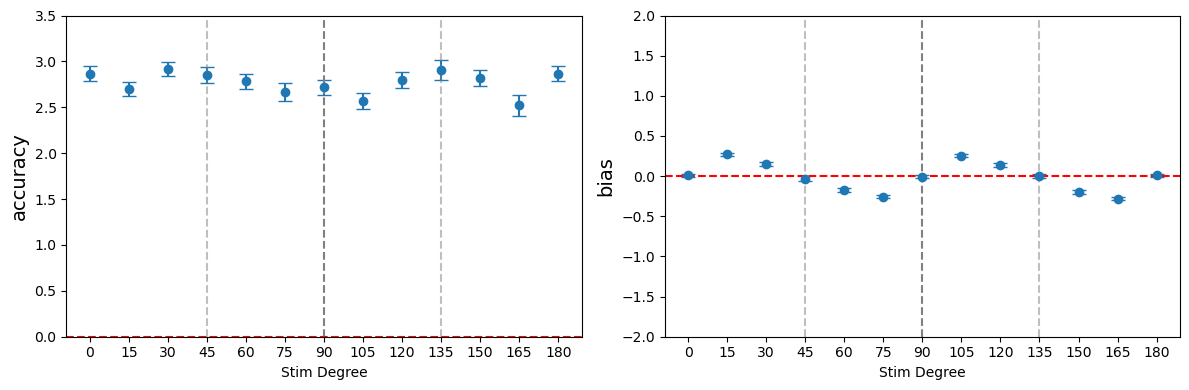

In [17]:
default_lmb = lambda d: np.ones(d.shape[0], dtype=bool)
display_acc_bias_as_tuning(default_lmb, 'all')

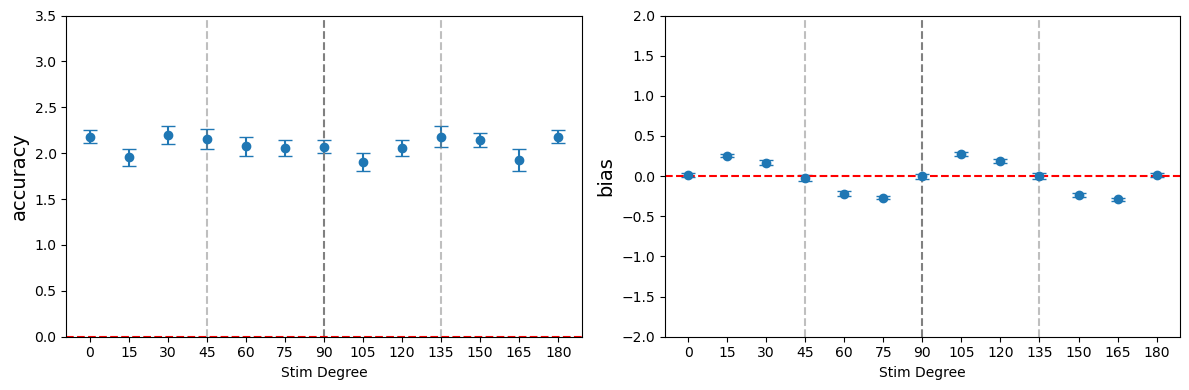

In [18]:
display_acc_bias_as_tuning(draw_lmb, 'draw')

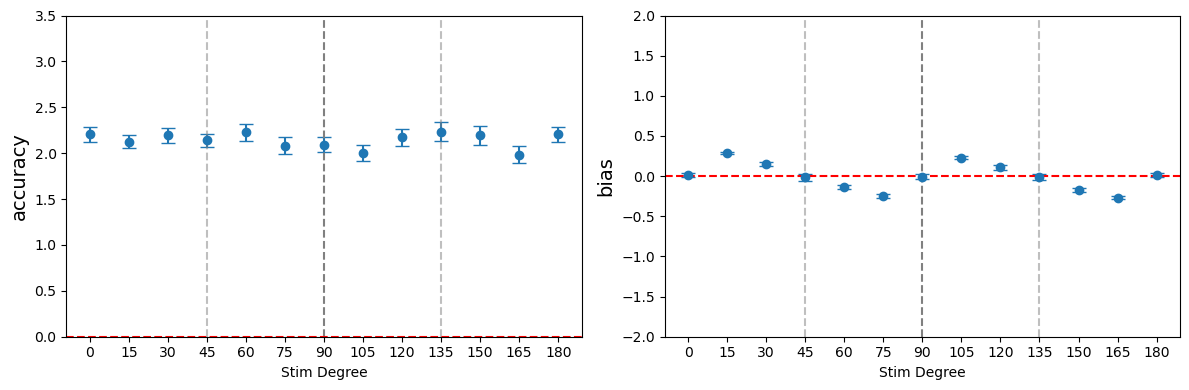

In [19]:
display_acc_bias_as_tuning(click_lmb, 'click')

### Show cardinal / oblique bias as a function

In [25]:
from utils.behav_analysis_helper import errdf_to_stim_distrib

def plot_behav_bias_stim_distrib(
        ax, lmb=None, ref_type=None, to_flip=False,
        **kwargs):
    
    ref = {
        'target': None,
        'previous': 'prev_resp',
        'nontarget': 'non_target',
    }[ref_type]

    es = deg_signed_diff(np.arange(180))
    es[es > 30] = 0 # mask out the big errors

    if to_flip:
        es = np.abs(es)

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)
        distrib = errdf_to_stim_distrib(err_df, ref=ref)

        if len(distrib) == 0:
            continue

        # apply smoothing
        distrib = np.dot(
            SMOOTHING_WEIGHTS, distrib)
        distrib = distrib / np.sum(distrib, axis=1, keepdims=True)

        # compute average errors
        err_curve = np.sum(es * distrib, axis=-1)

        subj_names.append(int(subj))
        subj_data.append(err_curve)

    # plot the result
    subj_mean = np.mean(subj_data, axis=0)
    subj_std = np.std(subj_data, axis=0)
    subj_sem = subj_std / np.sqrt(len(subj_data))

    # plot
    ax.plot(
        np.arange(180), subj_mean,
        label=kwargs.get('label'), 
        color=kwargs.get('color'), 
        alpha=1.0)
    ax.fill_between(
        np.arange(180), 
        subj_mean - subj_sem, 
        subj_mean + subj_sem,
        color=kwargs.get('color'), 
        alpha=0.5)

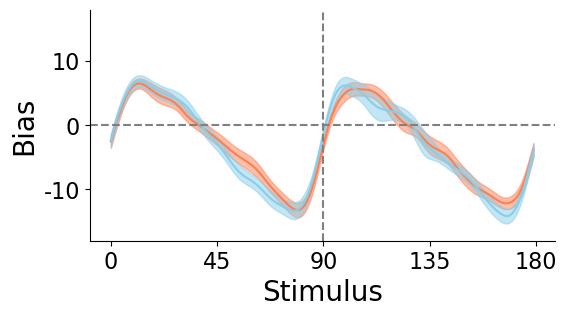

In [45]:
fig, ax = plt.subplots(1, figsize=(6, 3))

click_accs = plot_behav_bias_stim_distrib(
    ax, lmb=click_lmb, ref_type='target',
    label='click', color=MODE_COLORS['click'])
draw_accs = plot_behav_bias_stim_distrib(
    ax, lmb=draw_lmb, ref_type='target',
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Stimulus', fontsize=20)
ax.set_ylabel('Bias', fontsize=20)
ax.set_ylim([-18, 18])
xticks = np.arange(5) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = np.arange(-1, 2, 1) * 10
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.axhline(0, color='gray', linestyle='--')
ax.axvline(90, color='gray', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=16)

#### Error as a function of stim

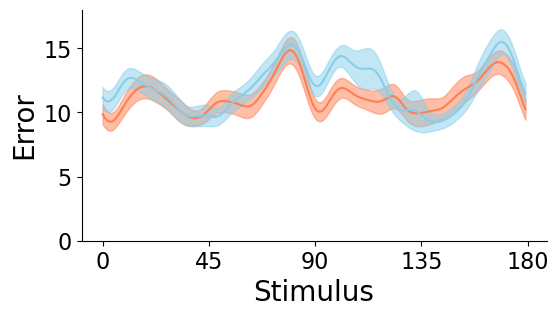

In [42]:
fig, ax = plt.subplots(1, figsize=(6, 3))

click_accs = plot_behav_bias_stim_distrib(
    ax, lmb=click_lmb, ref_type='target', to_flip=True,
    label='click', color=MODE_COLORS['click'])
draw_accs = plot_behav_bias_stim_distrib(
    ax, lmb=draw_lmb, ref_type='target', to_flip=True,
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Stimulus', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
ax.set_ylim([0, 18])
xticks = np.arange(5) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = np.arange(4) * 5
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### As a function of stim difference

In [40]:
from utils.behav_analysis_helper import errdf_to_stim_distrib

def plot_behav_err_stim_diff_distrib(ax, lmb=None, **kwargs):
    es = deg_signed_diff(np.arange(180))
    es = np.abs(es)  # use absolute error
    es[es > 30] = 0 # remove error too large

    # collect subject data
    subj_names = []
    subj_data = []
    for subj in all_subjs:
        behav_data = load_subj_behav_data(subj)
        err_df = df_to_errs(behav_data, lmb)

        diffs = deg_signed_diff(
            err_df['non_target'] - err_df['stim']).values
        diffs = np.round(diffs).astype(int) % 180
        errs = err_df['err'].values
        errs = np.round(errs).astype(int) % 180

        subj_freq = np.zeros((180, 180))
        np.add.at(subj_freq, (diffs, errs), 1)

        # smoothing
        distrib = np.dot(SMOOTHING_WEIGHTS, subj_freq)
        distrib = distrib / np.sum(distrib, axis=1, keepdims=True)

        # compute average errors
        err_curve = np.sum(es * distrib, axis=-1)

        subj_names.append(int(subj))
        subj_data.append(err_curve)

    # plot the result
    subj_mean = np.mean(subj_data, axis=0)
    subj_std = np.std(subj_data, axis=0)
    subj_sem = subj_std / np.sqrt(len(subj_data))

    plot_xs = deg_signed_diff(np.arange(180))
    sort_ids = np.argsort(plot_xs)

    # plot
    ax.plot(
        plot_xs[sort_ids], subj_mean[sort_ids],
        label=kwargs.get('label'), 
        color=kwargs.get('color'), 
        alpha=1.0)
    ax.fill_between(
        plot_xs[sort_ids], 
        (subj_mean - subj_sem)[sort_ids], 
        (subj_mean + subj_sem)[sort_ids],
        color=kwargs.get('color'), 
        alpha=0.5)
    ax.set_xlabel(r'\|s_1 - s_2\|')
    ax.set_ylabel(r'\|e_1 - e_2\|')
    

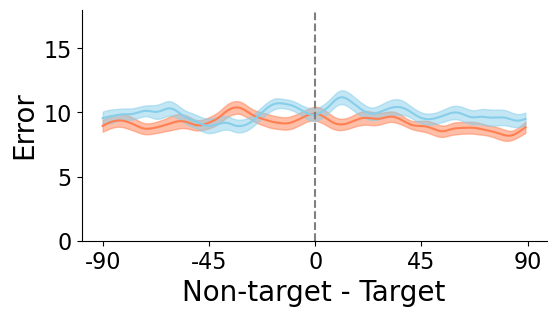

In [43]:
fig, ax = plt.subplots(1, figsize=(6, 3))

click_accs = plot_behav_err_stim_diff_distrib(
    ax, lmb=click_lmb, 
    label='click', color=MODE_COLORS['click'])
draw_accs = plot_behav_err_stim_diff_distrib(
    ax, lmb=draw_lmb, 
    label='draw', color=MODE_COLORS['draw'])

ax.set_xlabel('Non-target - Target', fontsize=20)
ax.set_ylabel('Error', fontsize=20)
ax.set_ylim([0, 18])
xticks = np.arange(-2, 3) * 45
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=16)
yticks = [0, 5, 10, 15]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=16)
ax.axvline(0, color='gray', linestyle='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Get subjectwise behavior stats

In [24]:
from utils.behav_analysis_helper import subj_behav_df_to_stats

def compute_subj_behav_stats(lmb, stat_type):
    collected = {}
    for subj in all_subjs:
        if subj in invalid_subjs:
            continue
        subj_df = load_subj_behav_data(subj)
        stats = subj_behav_df_to_stats(
            subj_df, lmb,
            stim1_lmb=None, stim2_lmb=None,
            stat_type=stat_type)
        if stats is None:
            # subject do not have enough data...
            continue
        collected[subj] = stats

    return collected

#### Firstly, check accuracy

In [25]:
subj_acc_stats = compute_subj_behav_stats(default_lmb, 'accuracy')
subj_draw_accs = compute_subj_behav_stats(draw_lmb, 'accuracy')
subj_click_accs = compute_subj_behav_stats(click_lmb, 'accuracy')

In [26]:
import statsmodels.api as sm

def display_regression(ax, l1, l2):
    x_with_const = sm.add_constant(l1)
    model = sm.OLS(l2, x_with_const).fit()
    predictions = model.get_prediction(x_with_const)
    summary_frame = predictions.summary_frame(alpha=0.05)

    # Get confidence intervals of the model
    conf_int = model.conf_int(alpha=0.05)

    # Get standard errors
    y_pred = summary_frame['mean']                 # Predicted values
    ci_lower = summary_frame['mean_ci_lower']      # Lower bound of confidence interval
    ci_upper = summary_frame['mean_ci_upper']

    # also get estimate of parameters
    params = model.params

    # plot it
    order = np.argsort(l1)
    ax.plot(l1[order], y_pred[order], color='red', label=f'Regression Line: y={model.params[1]:.2f}x+{model.params[0]:.2f}')
    ax.fill_between(l1[order], ci_lower[order], ci_upper[order], color='gray', alpha=0.3)

    # show p value
    p_values = model.pvalues
    # print(p_values)
    return conf_int, p_values, params

def display_regression_with_plot(l1, l2, xlabel, ylabel, plot_name, show_conf_int=False, mark_median=True):
    _, ax = plt.subplots(1, figsize=(3, 3))
    ax.scatter(l1, l2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    conf_int, pval, params = display_regression(ax, l1, l2)
    ax.set_title(f'p-val: {pval[1]:.4f}')

    # also mark the median
    if mark_median:
        median_x = np.median(l1)
        median_y = np.median(l2)
        ax.axvline(median_x, color='y', alpha=0.5, linestyle='--')
        ax.axhline(median_y, color='y', alpha=0.5, linestyle='--')

    plot_path = os.path.join(
        PLOTS_FOLDER, f'{plot_name}.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # print confidence intervals
    if show_conf_int:
        print(f'Estimate: {params}')
        print(f'Confidence intervals: {conf_int}')

    return ax

def dispalay_regression_dicts(
        dict1, dict2, xlabel, ylabel, plot_name, show_conf_int=False, mark_median=True):
    shared_keys = set(dict1.keys()).intersection(set(dict2.keys()))
    l1 = np.array([dict1[k] for k in shared_keys])
    l2 = np.array([dict2[k] for k in shared_keys])
    ax = display_regression_with_plot(
        l1, l2, xlabel, ylabel, plot_name, show_conf_int=show_conf_int, mark_median=mark_median)
    return ax

##### load gaze acc

In [27]:
gaze_stats_path = os.path.join(
    RESULTS_PATH, 'stats', 'gaze', 'inverted_enc')

In [28]:
DEFAULT_BEHAV_THRESH = 3.5
DEFAULT_GAZE_THRESH = 0.0

In [29]:
def load_acc_stats(gaze_stats_name, stim_name='combined'):
        gaze_acc_path = os.path.join(gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
                gaze_acc = json.load(f)
        if stim_name in gaze_acc:
                gaze_acc = gaze_acc[stim_name]['accuracy']
        else:
                gaze_acc = gaze_acc['stim 1']['accuracy']
        return gaze_acc

def compare_gaze_behav_acc(gaze_stats_name, behav_stats, plot_name,
                gaze_acc_thresh=DEFAULT_GAZE_THRESH, behav_acc_thresh=DEFAULT_BEHAV_THRESH):
        gaze_acc = load_acc_stats(gaze_stats_name)
        # filter by accuracy
        gaze_acc = {k: v for k, v in gaze_acc.items() if v > gaze_acc_thresh}
        behav_stats = {k: v for k, v in behav_stats.items() if v > behav_acc_thresh}

        # compare gaze and behav
        dispalay_regression_dicts(
                gaze_acc, behav_stats,
                'Gaze Accuracy', 'Behavior Accuracy',
                plot_name)


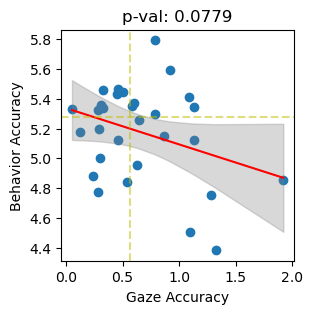

In [30]:
compare_gaze_behav_acc(
    'enc1_after_cue_combined', subj_acc_stats, 'reg_behav_gaze_enc_acc')

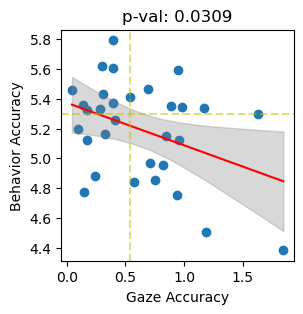

In [31]:
compare_gaze_behav_acc(
    'whole_isi_combined', subj_acc_stats, 'reg_behav_gaze_isi_acc')

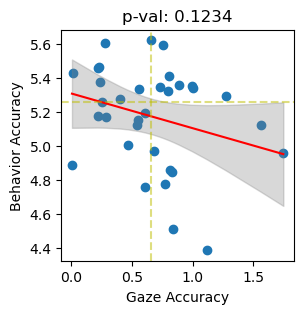

In [32]:
compare_gaze_behav_acc(
    'whole_delay_combined', subj_acc_stats, 'reg_behav_gaze_delay_acc')

### what about across phase decoding?

In [33]:
enc_isi_generalizability = {}
gaze_enc_acc = load_acc_stats('enc1_after_cue_combined')
gaze_isi_acc = load_acc_stats('whole_isi_combined')
gaze_enc_isi_acc = load_acc_stats('enc1_isi_combined')
gaze_enc_acc_cutoff = np.percentile(list(gaze_enc_acc.values()), 30)
gaze_isi_acc_cutoff = np.percentile(list(gaze_isi_acc.values()), 30)
print(gaze_enc_acc_cutoff, gaze_isi_acc_cutoff)
for k in gaze_enc_acc.keys():
    if (gaze_enc_acc[k] < gaze_enc_acc_cutoff) or (gaze_isi_acc[k] < gaze_isi_acc_cutoff):
        continue
    enc_isi_generalizability[k] = gaze_enc_isi_acc[k] / np.sqrt(
        gaze_enc_acc[k] * gaze_isi_acc[k])

0.2968171692535815 0.26107900813137364


<Axes: title={'center': 'p-val: 0.7115'}, xlabel='Enc -> ISI Generalizability', ylabel='Behavior Accuracy'>

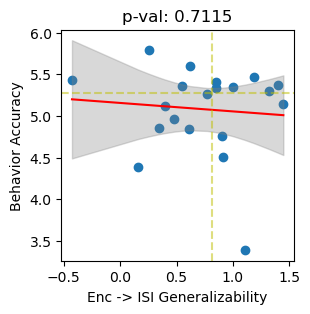

In [34]:
dispalay_regression_dicts(
    enc_isi_generalizability, 
    subj_acc_stats,
    'Enc -> ISI Generalizability', 
    'Behavior Accuracy', 
    'reg_enc_isi_gen_vs_behav_acc')

In [35]:
isi_delay_generalizability = {}
gaze_delay_acc = load_acc_stats('whole_delay_combined')
gaze_isi_delay_acc = load_acc_stats('isi_delay_combined')
gaze_isi_acc_cutoff = np.percentile(list(gaze_isi_acc.values()), 30)
gaze_delay_acc_cutoff = np.percentile(list(gaze_delay_acc.values()), 30)
for k in gaze_isi_acc.keys():
    if (gaze_isi_acc[k] < gaze_isi_acc_cutoff) or (gaze_delay_acc[k] < gaze_delay_acc_cutoff):
        continue
    gen_val = gaze_isi_delay_acc[k] / np.sqrt(
        gaze_isi_acc[k] * gaze_delay_acc[k])
    isi_delay_generalizability[k] = gen_val

<Axes: title={'center': 'p-val: 0.0066'}, xlabel='ISI -> Delay Generalizability', ylabel='Behavior Accuracy'>

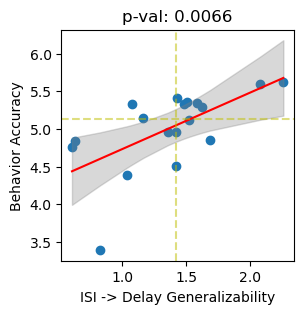

In [36]:
dispalay_regression_dicts(
    isi_delay_generalizability, 
    subj_acc_stats,
    'ISI -> Delay Generalizability', 
    'Behavior Accuracy', 
    'reg_isi_delay_gen_vs_behav_acc')

#### Now examine whether gaze/behavior draw/wheel accuracy interact

In [37]:
def load_hand_stats(stim_name):
        acc_file_path = os.path.join(
                RESULTS_PATH, 'stats', 'hand', 'inverted_enc', 
                'whole_delay_combined', 'accuracy.json')
        with open(acc_file_path) as f:
                hand_acc = json.load(f)
        hand_acc = hand_acc[stim_name]['accuracy']
        return hand_acc

In [38]:
hand_draw_acc_combined = load_hand_stats('draw')
hand_click_acc_combined = load_hand_stats('click')
gaze_draw_acc_combined = load_acc_stats('whole_delay_combined', 'draw')
gaze_click_acc_combined = load_acc_stats('whole_delay_combined', 'click')

In [39]:
metric_dicts = {
    'hand_draw': hand_draw_acc_combined,
    'hand_click': hand_click_acc_combined,
    'gaze_draw': gaze_draw_acc_combined,
    'gaze_click': gaze_click_acc_combined,
}

# Combine into one DataFrame
metric_2x2_df = pd.DataFrame(metric_dicts)

**comments**: since evidence < 0 does not make sense...in the following analysis all negative evidence are converted to 0 (invalid, no-evidence). Since we are only doing pairwise comparison and comparing the differences it should not matter.

In [40]:
TO_CONVERT_NEG = True

In [41]:
# metric_2x2_cleaned = metric_2x2_df[metric_2x2_df.gt(-0.0).all(axis=1)]
metric_2x2_cleaned = metric_2x2_df.copy()
if TO_CONVERT_NEG:
    metric_2x2_cleaned[metric_2x2_cleaned < 0] = 0.0

In [43]:
def plot_paired_data(df, c1, c2, c1_name, c2_name, c1_color, c2_color):
    fig, ax = plt.subplots(figsize=(5, 7))
    xs = np.arange(2)
    
    # paired
    for _, row in df.iterrows():
        ax.plot(
            xs, row.values,linewidth=2,
            color='gray', alpha=0.3)

    # scatter
    ax.plot(
        np.zeros(len(df)), df[c1], marker='o', linestyle='',
        markeredgecolor='gray',
        color=c1_color, alpha=1.0)
    ax.plot(
        np.ones(len(df)), df[c2], marker='o', linestyle='',
        markeredgecolor='gray',
        color=c2_color, alpha=1.0)

    # fix x-axis
    ax.set_xticks(xs)
    ax.set_xticklabels([c1_name, c2_name], fontsize=14)
    ax.set_xlim([-0.5, 1.5])
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return ax

$r=-0.394$,$p=0.0174$


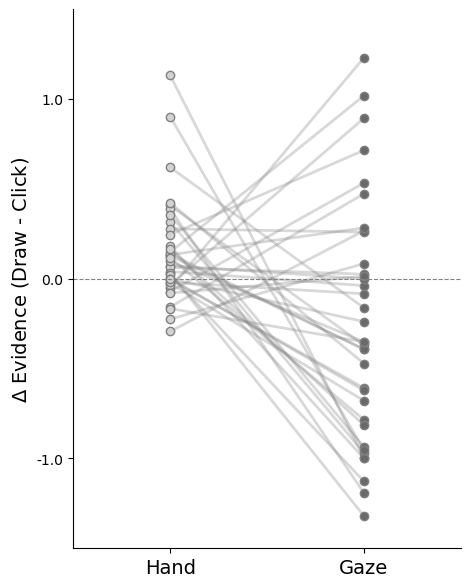

In [45]:
mode_d_df = pd.DataFrame({
    'd_hand': metric_2x2_cleaned['hand_draw'] - metric_2x2_cleaned['hand_click'],
    'd_gaze': metric_2x2_cleaned['gaze_draw'] - metric_2x2_cleaned['gaze_click']
})

# Plot
ax = plot_paired_data(
    mode_d_df, 
    c1='d_hand', c2='d_gaze', 
    c1_name='Hand', c2_name='Gaze',
    c1_color='lightgray', c2_color='dimgray'
)

ax.set_ylim([-1.5, 1.5])
yticks = [-1.0, 0.0, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=10)
ax.set_ylabel(r'$\Delta$ Evidence (Draw - Click)', fontsize=14)

# run correlation test
from scipy.stats import pearsonr

r, p = pearsonr(
    mode_d_df['d_hand'], 
    mode_d_df['d_gaze'])

print(f"$r={r:.3f}$,$p={p:.4f}$")


#### Figure: add the comparison for different modes

In [47]:
from scipy.stats import wilcoxon

def get_iqr_stats(s):
    med = s.median()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    return f"$Mdn={med:.2f}$, $IQR=[{q1:.2f}, {q3:.2f}]$"

def display_wilcoxon_test_result(s1, s2, s1_name, s2_name):
    stat, p = wilcoxon(s1, s2)
    s1_med_str = get_iqr_stats(s1)
    s2_med_str = get_iqr_stats(s2)
    wilcoxon_str = "Wilcoxon signed ranked test reveals " 
    if p < 0.05:
        wilcoxon_str += "a significant difference"
    else:
        wilcoxon_str += "no significant difference"
    wilcoxon_str += f" ($W={int(stat)}$, $n={len(s1)}$, $p={p:.4f}$)"

    conclusion = (
        f"comparing {s1_name} condition ({s1_med_str}) "
        f"vs {s2_name} condition ({s2_med_str}), "
        f"{wilcoxon_str}."
    )

    print(conclusion)

comparing 'draw' condition ($Mdn=0.37$, $IQR=[0.08, 0.88]$) vs 'click' condition ($Mdn=0.66$, $IQR=[0.31, 1.10]$), Wilcoxon signed ranked test reveals a significant difference ($W=182$, $n=36$, $p=0.0294$).


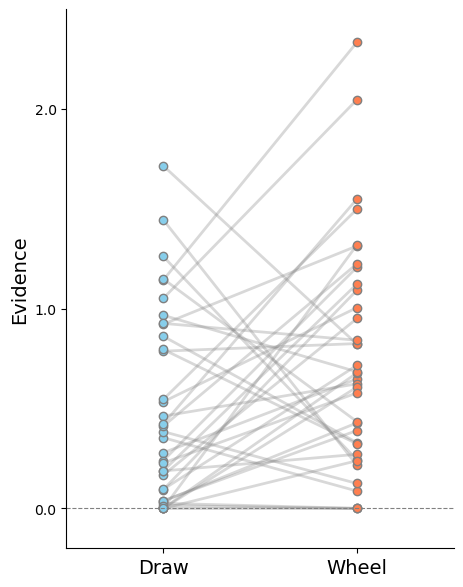

In [48]:
# for gaze data

gaze_metric_cleaned = metric_2x2_df[['gaze_draw', 'gaze_click']].copy()
if TO_CONVERT_NEG:
    gaze_metric_cleaned[gaze_metric_cleaned < 0] = 0.0

ax = plot_paired_data(
    gaze_metric_cleaned, 
    c1='gaze_draw', c2='gaze_click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click']
)

ax.set_ylim([-0.2, 2.5])
yticks = [0.0, 1.0, 2.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=10)
ax.set_ylabel('Evidence', fontsize=14)

# apply wilcoxon signed-rank test
display_wilcoxon_test_result(
    gaze_metric_cleaned['gaze_draw'], 
    gaze_metric_cleaned['gaze_click'],
    "'draw'", "'click'")

comparing 'draw' condition ($Mdn=0.20$, $IQR=[0.06, 0.64]$) vs 'click' condition ($Mdn=0.11$, $IQR=[0.01, 0.38]$), Wilcoxon signed ranked test reveals a significant difference ($W=132$, $n=36$, $p=0.0047$).


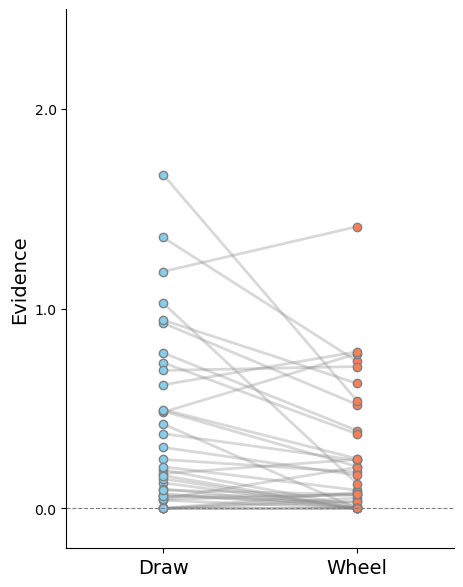

In [49]:
# for hand data

hand_metric_cleaned = metric_2x2_df[['hand_draw', 'hand_click']].copy()
if TO_CONVERT_NEG:
    hand_metric_cleaned[hand_metric_cleaned < 0] = 0.0

ax = plot_paired_data(
    hand_metric_cleaned, 
    c1='hand_draw', c2='hand_click', 
    c1_name='Draw', c2_name='Wheel',
    c1_color=MODE_COLORS['draw'], c2_color=MODE_COLORS['click']
)

ax.set_ylim([-0.2, 2.5])
yticks = [0.0, 1.0, 2.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=10)
ax.set_ylabel('Evidence', fontsize=14)

# apply wilcoxon signed-rank test
display_wilcoxon_test_result(
    hand_metric_cleaned['hand_draw'], 
    hand_metric_cleaned['hand_click'],
    "'draw'", "'click'")

### split modes

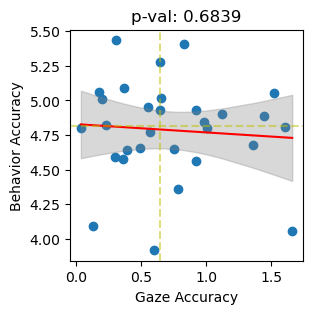

In [33]:
compare_gaze_behav_acc(
    'whole_delay_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_acc')

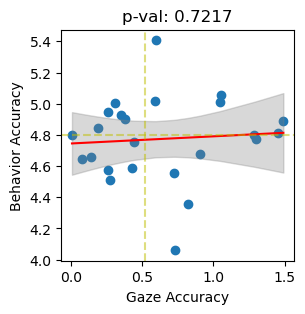

In [34]:
compare_gaze_behav_acc(
    'delay_first_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_start_acc')

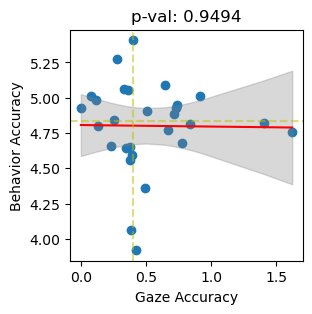

In [35]:
compare_gaze_behav_acc(
    'delay_last_phase_draw2draw', subj_draw_accs, 
    'reg_draw_behav_gaze_delay_end_acc')

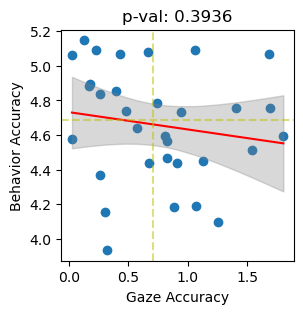

In [36]:
compare_gaze_behav_acc(
    'whole_delay_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_acc')

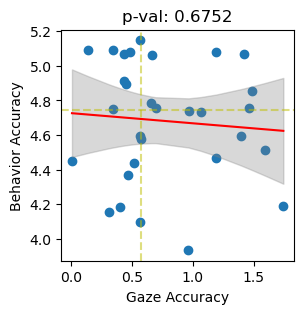

In [37]:
compare_gaze_behav_acc(
    'delay_first_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_start_acc')

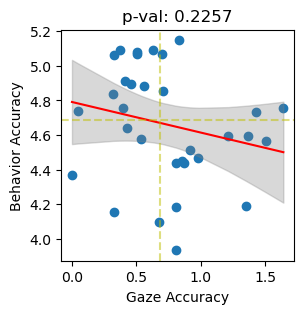

In [38]:
compare_gaze_behav_acc(
    'delay_last_phase_click2click', subj_click_accs, 
    'reg_click_behav_gaze_delay_end_acc')

#### serial bias

In [39]:
def compare_gaze_behav_sd_bias(gaze_stats_name, behav_stats, plot_name, acc_filter=False):
    gaze_bias_path = os.path.join(gaze_stats_path, gaze_stats_name, 'sd.json')
    with open(gaze_bias_path) as f:
        gaze_bias = json.load(f)
    if 'combined' in gaze_bias:
        gaze_bias = gaze_bias['combined']['bias']
    else:
        gaze_bias = gaze_bias['stim 1']['bias']

    # remove those of acc below baseline
    if acc_filter:
        gaze_acc_path = os.path.join(
            gaze_stats_path, gaze_stats_name, 'accuracy.json')
        with open(gaze_acc_path) as f:
            gaze_acc = json.load(f)
        if 'combined' in gaze_acc:
            gaze_acc = gaze_acc['combined']['accuracy']
        else:
            gaze_acc = gaze_acc['stim 1']['accuracy']
        gaze_bias = {k:v for k,v in gaze_bias.items() 
            if gaze_acc[k] > DEFAULT_GAZE_THRESH}
        behav_stats = {k:v for k,v in behav_stats.items()
            if subj_acc_stats[k] > DEFAULT_BEHAV_THRESH}

    # compare gaze and behav
    dispalay_regression_dicts(
        gaze_bias, behav_stats,
        'Gaze Serial Bias', 'Behavior Serial Bias',
        plot_name)

In [40]:
subj_sd_stats = compute_subj_behav_stats(default_lmb, 'sd')
subj_draw_sds = compute_subj_behav_stats(draw_lmb, 'sd')
subj_click_sds = compute_subj_behav_stats(click_lmb, 'sd')

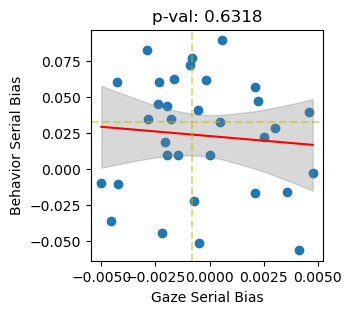

In [41]:
compare_gaze_behav_sd_bias(
    'whole_delay_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_sd',
    acc_filter=True)

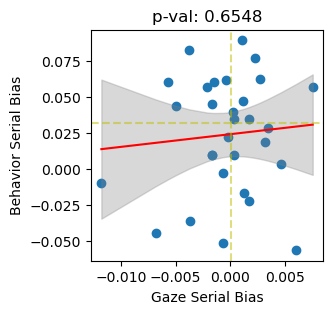

In [42]:
compare_gaze_behav_sd_bias(
    'whole_delay_draw2draw', subj_sd_stats, 
    'reg_behav_gaze_draw_delay_sd',
    acc_filter=True)

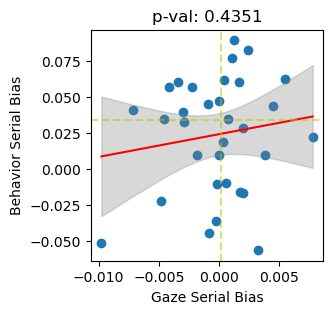

In [43]:
compare_gaze_behav_sd_bias(
    'whole_delay_click2click', subj_sd_stats, 
    'reg_behav_gaze_click_delay_sd',
    acc_filter=True)

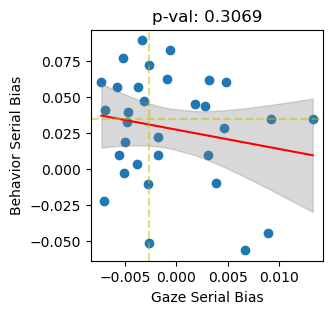

In [44]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_combined', subj_sd_stats, 
    'reg_behav_gaze_delay_end_sd',
    acc_filter=True)

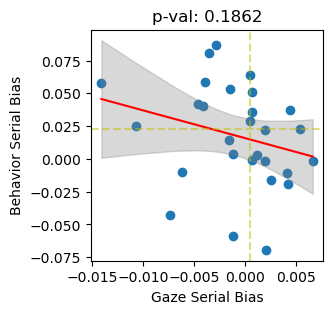

In [45]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_draw2draw', subj_draw_sds, 
    'reg_draw_behav_gaze_delay_end_sd',
    acc_filter=True)

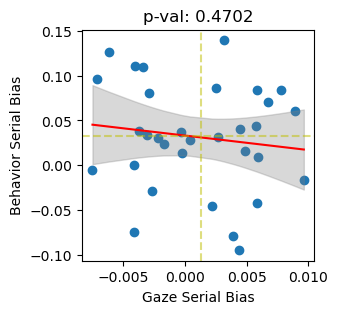

In [46]:
compare_gaze_behav_sd_bias(
    'delay_last_phase_click2click', subj_click_sds, 
    'reg_click_behav_gaze_delay_end_sd',
    acc_filter=True)

**comments**: unfortunately...

##### Try taking the average over the end of delay...

In [47]:
TRIAL_TIMEPOINT_PRED_PATH = os.path.join(gaze_stats_path, 'predictions')

In [48]:
last_phase_ids = [8, 9, 10]
def load_avg_preds(mode, phase_ids, lmb, align_type):
    mode_path = os.path.join(TRIAL_TIMEPOINT_PRED_PATH, f'{mode}_delay_phase')
    df = pd.read_csv(os.path.join(mode_path, 'y_df.csv'), index_col=0)
    select_mask = lmb(df) if lmb is not None else np.ones(df.shape[0], dtype=bool)
    stim_masks = {
        'stim_1': select_mask.copy(),
        'stim_2': select_mask.copy(),
    }
    preds = [[], []]
    for pid in phase_ids:
        for i, stim_id in enumerate(['stim_1', 'stim_2']):
            loaded = np.load(
                os.path.join(mode_path, f'phase_{pid}', 
                    'aligned', stim_id, f'{align_type}.npy'), 
                allow_pickle=True)
            load_valid_mask = (~(np.isnan(loaded[:, 0]))) & stim_masks[stim_id]
            stim_masks[stim_id] = stim_masks[stim_id] & load_valid_mask
            # print(np.sum(select_mask))
            preds[i].append(loaded[load_valid_mask])
    preds = [np.mean(ps, axis=0) for ps in preds]
    dfs = [df[stim_masks[stim_id]] for stim_id in ['stim_1', 'stim_2']]
    return dfs, preds

In [49]:
draw_last_phase_target_avg = load_avg_preds('draw', last_phase_ids, None, 'target')
click_last_phase_target_avg = load_avg_preds('click', last_phase_ids, None, 'target')

In [50]:
draw_last_phase_prev_avg = load_avg_preds('draw', last_phase_ids, None, 'previous')
click_last_phase_prev_avg = load_avg_preds('click', last_phase_ids, None, 'previous')

In [51]:
def last_phase_avg_to_stats(df, avg_preds, stat_type, acc_thresh=DEFAULT_GAZE_THRESH):
    # we don't care stim 1 or 2 just collapse them
    df = pd.concat((df[0], df[1]), axis=0, ignore_index=True)
    avg_preds = np.concatenate((avg_preds[0], avg_preds[1]), axis=0)

    subjects = df['participant'].to_numpy()
    all_subj_stats = {}
    for subj in all_subjs:
        subj_mask = subjects == int(subj)
        if np.sum(subj_mask) == 0:
            # subject do not have enough data...
            continue
        subj_preds = avg_preds[subj_mask]
        subj_distrib = np.mean(subj_preds, axis=0)
        subj_distrib = subj_distrib / np.sum(subj_distrib)
        stat_func = compute_accuracy if stat_type == 'accuracy' else compute_bias
        stat = stat_func(subj_distrib, T=180)
        all_subj_stats[subj] = stat

    if acc_thresh is not None:
        # remove those of acc below baseline
        all_subj_stats = {k: v for k, v in all_subj_stats.items() 
            if subj_acc_stats[k] > acc_thresh}

    return all_subj_stats

In [52]:
gaze_draw_last_phase_avg_acc = last_phase_avg_to_stats(
    draw_last_phase_target_avg[0], 
    draw_last_phase_target_avg[1],
    'accuracy'
)

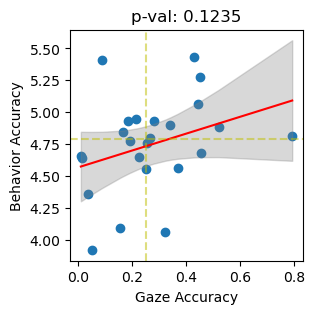

In [53]:
gacc = {k:v for k, v in gaze_draw_last_phase_avg_acc.items() if v > DEFAULT_GAZE_THRESH}
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gacc, bacc,
    'Gaze Accuracy', 'Behavior Accuracy',
    'reg_draw_last_phase_avg_acc')

In [54]:
gaze_draw_last_phase_avg_sd = last_phase_avg_to_stats(
    draw_last_phase_prev_avg[0], 
    draw_last_phase_prev_avg[1],
    'bias'
)

In [55]:
gaze_click_last_phase_avg_sd = last_phase_avg_to_stats(
    click_last_phase_prev_avg[0], 
    click_last_phase_prev_avg[1],
    'bias'
)

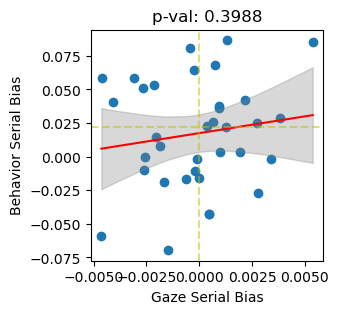

In [56]:
gsd = gaze_draw_last_phase_avg_sd
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_draw_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_draw_last_phase_avg_sd')

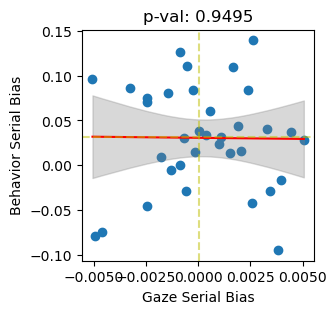

In [57]:
gsd = gaze_click_last_phase_avg_sd
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
bsd = {k:subj_click_sds[k] for k in bacc}
dispalay_regression_dicts(
    gsd, bsd,
    'Gaze Serial Bias', 'Behavior Serial Bias',
    'reg_click_last_phase_avg_sd')

##### check if there are some interaction between acc and sd...

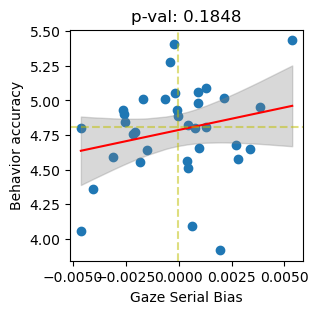

In [58]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_draw_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_draw_gaze_sd')

# one subject kicked out for bad performance (outlier, below 3.5)

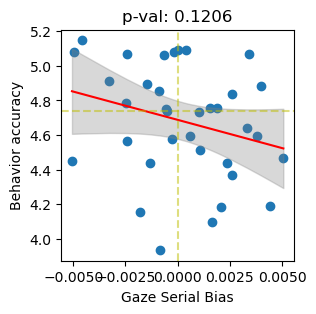

In [59]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    gaze_click_last_phase_avg_sd, 
    bacc,
    'Gaze Serial Bias', 
    'Behavior accuracy', 
    'reg_behav_acc_click_gaze_sd')

##### lastly, does accuracy has anything to do with SD in behavior?

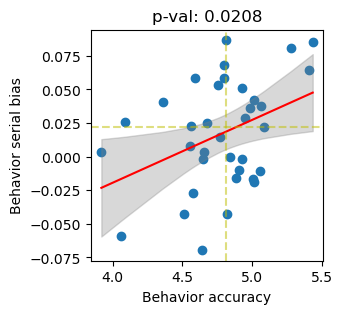

In [60]:
bacc = {k:v for k, v in subj_draw_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    bacc, 
    subj_draw_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_draw_behav_acc_sd')

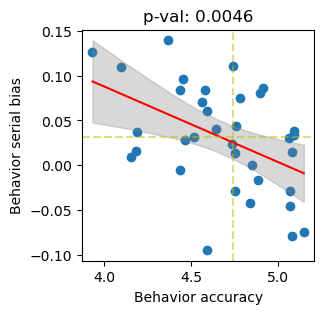

In [61]:
bacc = {k:v for k, v in subj_click_accs.items() if v > DEFAULT_BEHAV_THRESH}
dispalay_regression_dicts(
    bacc, 
    subj_click_sds,
    'Behavior accuracy', 
    'Behavior serial bias', 
    'reg_click_behav_acc_sd')

#### Not really behavior analysis but we make use of the code here...

In [62]:
bacc = {k:v for k, v in subj_acc_stats.items() if v > DEFAULT_BEHAV_THRESH}

In [83]:
def confine_ratio_compare(ax):
    ax.set_ylim([-1, 2.5])
    ax.set_xlim([-1, 2.5])
    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1, 2])

    # mark 0
    ax.axvline(0, color='y', alpha=0.5, linestyle='--')
    ax.axhline(0, color='y', alpha=0.5, linestyle='--')


Estimate: [0.35309479 0.56008023]
Confidence intervals: [[0.22410835 0.48208124]
 [0.38078156 0.7393789 ]]


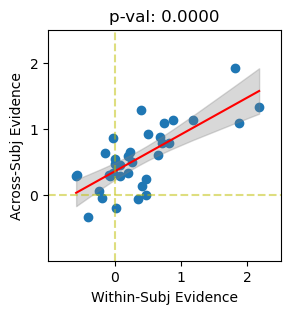

In [89]:
acc_within_subj_enc = load_acc_stats('within_subj_enc1_after_cue_combined')
acc_across_subj_enc = load_acc_stats('enc1_after_cue_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_enc_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False)

confine_ratio_compare(ax)


Estimate: [0.22555831 0.64976813]
Confidence intervals: [[0.09917024 0.35194637]
 [0.48998045 0.80955582]]


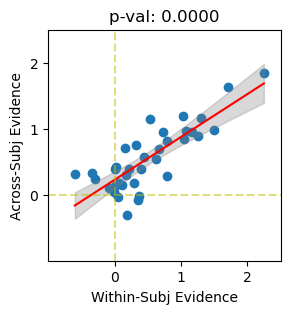

In [90]:
acc_within_subj_enc = load_acc_stats('within_subj_isi_combined')
acc_across_subj_enc = load_acc_stats('whole_isi_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence', 
    'reg_isi_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False)
confine_ratio_compare(ax)

Estimate: [0.40067769 0.36198729]
Confidence intervals: [[0.23748732 0.56386806]
 [0.17362138 0.55035321]]


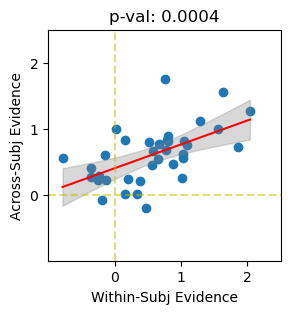

In [91]:
acc_within_subj_enc = load_acc_stats('within_subj_delay_combined')
acc_across_subj_enc = load_acc_stats('whole_delay_combined')

ax = dispalay_regression_dicts(
    acc_within_subj_enc, 
    acc_across_subj_enc,
    'Within-Subj Evidence', 
    'Across-Subj Evidence',
    'reg_delay_within_vs_across_subj',
    show_conf_int=True,
    mark_median=False)
confine_ratio_compare(ax)

##### Does across phase decoding quality has anything to do with behavior?

##### firstly, does the cross phase accuracy has any correlation?

In [62]:
acc_enc = load_acc_stats('enc1_after_cue_combined')
acc_enc_isi = load_acc_stats('enc1_isi_combined')
acc_enc_delay = load_acc_stats('enc1_delay_combined')
acc_isi = load_acc_stats('whole_isi_combined')
acc_isi_delay = load_acc_stats('isi_delay_combined')
acc_delay = load_acc_stats('whole_delay_combined')

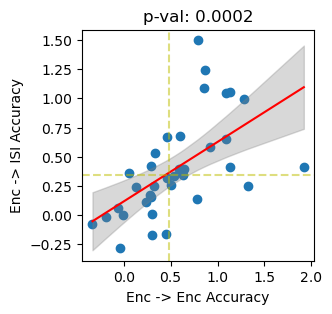

In [63]:
dispalay_regression_dicts(
    acc_enc, 
    acc_enc_isi,
    'Enc -> Enc Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_enc_vs_enc_isi')

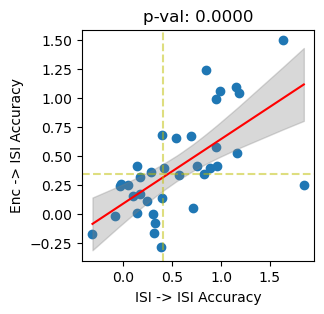

In [64]:
dispalay_regression_dicts(
    acc_isi, 
    acc_enc_isi,
    'ISI -> ISI Accuracy', 
    'Enc -> ISI Accuracy', 
    'reg_isi_vs_enc_isi')

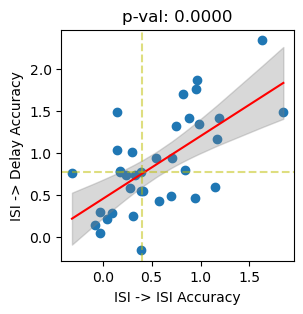

In [65]:
dispalay_regression_dicts(
    acc_isi, 
    acc_isi_delay,
    'ISI -> ISI Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_isi_vs_isi_delay')

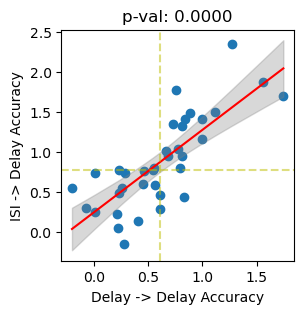

In [66]:
dispalay_regression_dicts(
    acc_delay, 
    acc_isi_delay,
    'Delay -> Delay Accuracy', 
    'ISI -> Delay Accuracy',
    'reg_delay_vs_isi_delay')

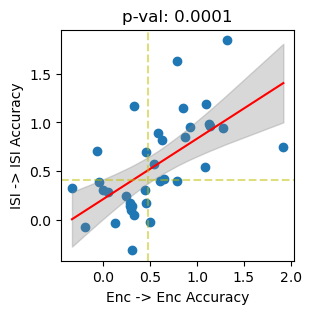

In [67]:
dispalay_regression_dicts(
    acc_enc,
    acc_isi,
    'Enc -> Enc Accuracy',
    'ISI -> ISI Accuracy',
    'reg_enc_vs_isi')

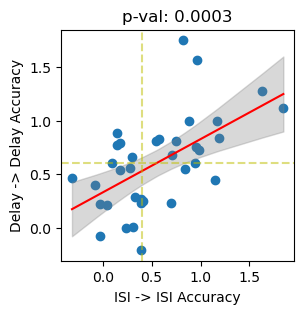

In [68]:
dispalay_regression_dicts(
    acc_isi,
    acc_delay,
    'ISI -> ISI Accuracy',
    'Delay -> Delay Accuracy', 
    'reg_isi_vs_delay')

##### Secondly, do any of these newly added acc has anything to do with behavior performance?

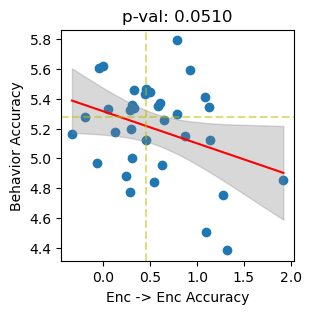

In [69]:
dispalay_regression_dicts(
    acc_enc, 
    bacc,
    'Enc -> Enc Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_vs_behav')

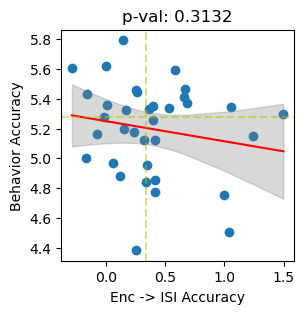

In [70]:
dispalay_regression_dicts(
    acc_enc_isi, 
    bacc,
    'Enc -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_isi_vs_behav')

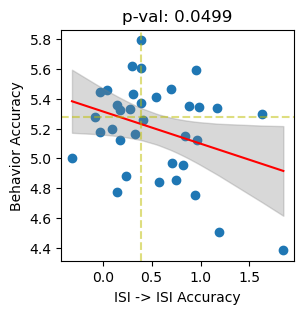

In [71]:
dispalay_regression_dicts(
    acc_isi, 
    bacc,
    'ISI -> ISI Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_vs_behav')

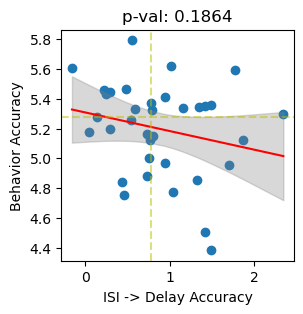

In [72]:
dispalay_regression_dicts(
    acc_isi_delay, 
    bacc,
    'ISI -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_isi_delay_vs_behav')

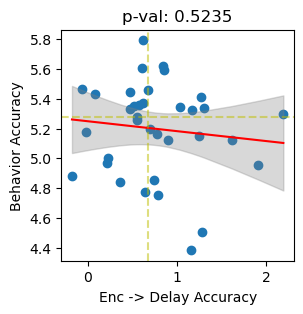

In [73]:
dispalay_regression_dicts(
    acc_enc_delay, 
    bacc,
    'Enc -> Delay Accuracy', 
    'Behavior Accuracy', 
    'reg_enc_delay_vs_behav')

**Comments** 

- Again None of them show any significant relationship with behavioral performance....
- But their are correlations between eye decodability at different phases.

## What about hand motions?

In [74]:
hand_stats_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'stats',
    'mouse', 'inverted_enc')

with open(os.path.join(hand_stats_path, 'draw', 'accuracy.json')) as f:
    hand_draw_acc = json.load(f)
    hand_draw_acc = hand_draw_acc['combined']['accuracy']

with open(os.path.join(hand_stats_path, 'click', 'accuracy.json')) as f:
    hand_click_acc = json.load(f)
    hand_click_acc = hand_click_acc['combined']['accuracy']


In [75]:
gaze_draw_acc = load_acc_stats('whole_delay_draw2draw')
gaze_click_acc = load_acc_stats('whole_delay_click2click')

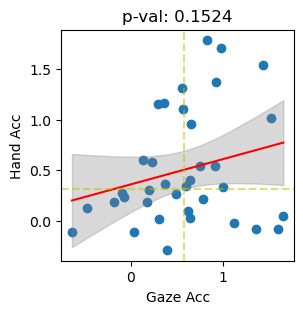

In [76]:
dispalay_regression_dicts(
    gaze_draw_acc, 
    hand_draw_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_draw_acc')

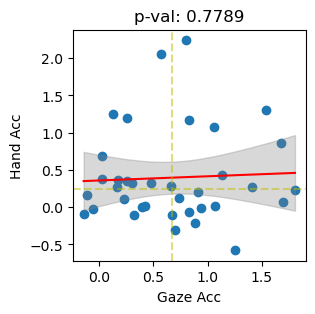

In [77]:
dispalay_regression_dicts(
    gaze_click_acc, 
    hand_click_acc,
    'Gaze Acc',
    'Hand Acc', 
    'reg_gaze_vs_hand_click_acc')

## Pull out survey questions

In [78]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [79]:
from utils.survey import preprocess_survey

survey_path = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'survey', 'survey_25Apr.csv')
survey_df = pd.read_csv(survey_path)
survey_df = preprocess_survey(survey_df)
survey_df['subject'] = survey_df.index.astype(str)
survey_df.reset_index(drop=True, inplace=True)

In [80]:
# keep only those in target subject list
target_survey = survey_df[survey_df['subject'].isin(all_subjs)]

### first check the strategy question

In [81]:
def plot_one_question(ax, df, qname, label_map, xmax=12):
    # label map: mapping numeric label to text
    labels, counts = np.unique(df[qname], return_counts=True)
    counts = {k:v for k,v in zip(labels, counts)}
    labels_sorted = [label for label in label_map.keys()] # if label in labels
    counts_sorted = [
        counts.get(label, 0) for label in labels_sorted]
    captions = [label_map[label] for label in labels_sorted]
    ax.barh(captions, counts_sorted, color='skyblue')
    for i, count in enumerate(counts_sorted):
        ax.text(count+0.8*xmax/10, i, str(count), va='center', ha='right')
    ax.set_yticks(np.arange(len(captions)))
    ax.set_yticklabels(captions)
    ax.invert_yaxis()
    if xmax is not None:
        ax.set_xlim([0, xmax])
    ax.set_xticks([])

In [82]:
from collections import OrderedDict

def plot_strategy_questions(survey_data, xmax=20):
    questions = OrderedDict([
        ('Q1.2', 'draw, null cue'),
        ('Q1.3', 'draw, informatic cue'),
        ('Q1.4', 'click, null cue'),
        ('Q1.5', 'click, informatic cue'),
    ])

    fig, axs = plt.subplots(1, len(questions), figsize=(4*len(questions), 3))
    for plot_id, qname in enumerate(list(questions.keys())):
        label_map = OrderedDict([
            (1, 'pictorial'), 
            (2, 'abstract'), 
            (3, 'action'), 
            # (4, 'mixed'), 
            # (5, 'other'),
        ])
        plot_one_question(axs[plot_id], survey_data, qname, label_map, xmax=xmax)
        axs[plot_id].set_title(questions[qname])
    plt.tight_layout()

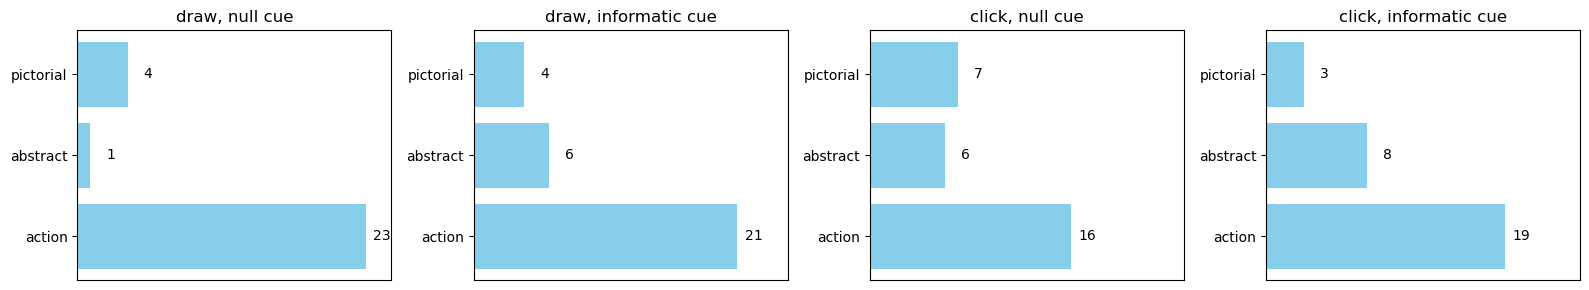

In [83]:
plot_strategy_questions(target_survey, xmax=25)
plot_path = os.path.join(
    PLOTS_FOLDER, 'strategy_questions.png')
plt.savefig(plot_path, bbox_inches='tight')

#### do strategies preference affect the accuracy?

In [84]:
strategy_dicts = target_survey[['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5', 'subject']].to_dict(orient='records')

In [85]:
def collect_multi_question_scores(dicts, qs, score_func):
    scores = {}
    for rec in dicts:
        s = [score_func(rec[q]) for q in qs]
        s = [s1 for s1 in s if s1 is not None]
        if len(s) == 0:
            continue
        s = np.mean(s)
        scores[rec['subject']] = s
    return scores

In [86]:
stat_q_score_func = lambda x: (x if x <=3 else None)
draw_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3'], stat_q_score_func)

In [87]:
click_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.4', 'Q1.5'], stat_q_score_func)

In [88]:
all_action_survey_scores = collect_multi_question_scores(
    strategy_dicts, ['Q1.2', 'Q1.3', 'Q1.4', 'Q1.5'], stat_q_score_func)

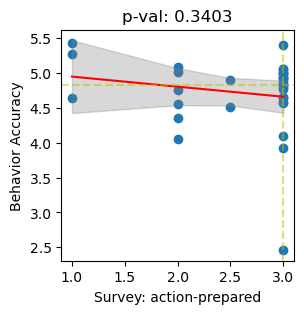

In [89]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    subj_draw_accs,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_draw_q1_vs_behav')

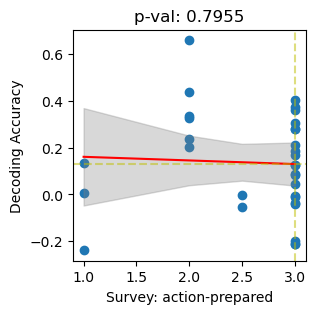

In [90]:
dispalay_regression_dicts(
    draw_action_survey_scores,
    gaze_draw_last_phase_avg_acc,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_draw_q1_vs_gaze_acc')

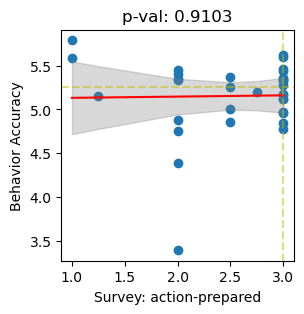

In [91]:
dispalay_regression_dicts(
    all_action_survey_scores,
    subj_acc_stats,
    'Survey: action-prepared', 
    'Behavior Accuracy', 
    'reg_q1_vs_behav')

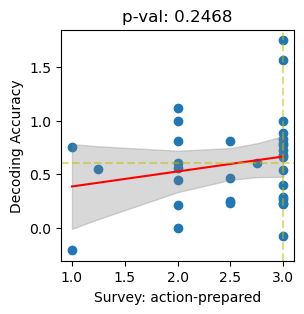

In [92]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_delay,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_delay')

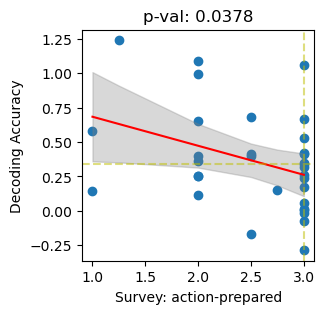

In [93]:
dispalay_regression_dicts(
    all_action_survey_scores,
    acc_enc_isi,
    'Survey: action-prepared', 
    'Decoding Accuracy', 
    'reg_q1_vs_gaze_acc_enc_isi')

**comment**: hehe

### Next we extract their answers to imagery question

In [94]:
def collect_imagery_question_scores(dicts, q, n_choices):
    scores = {}
    w = (n_choices + 1) / 2
    for rec in dicts:
        s = rec[q]
        s = (s - w) / w
        s = -s # originall smaller means more imagery
        scores[rec['subject']] = s
    return scores

In [95]:
imagery_dicts = target_survey[['Q6', 'Q7', 'subject']].to_dict(orient='records')

In [96]:
imagery_6_scores = collect_imagery_question_scores(imagery_dicts, 'Q6', 5)
imagery_7_scores = collect_imagery_question_scores(imagery_dicts, 'Q7', 3)

In [97]:
imagery_scores = {s: (imagery_6_scores[s] + imagery_7_scores[s])/2 for s in all_subjs}

#### Any correlation between questions?

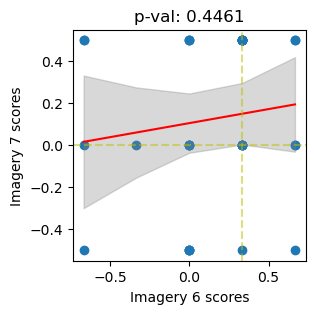

In [98]:
dispalay_regression_dicts(
    imagery_6_scores,
    imagery_7_scores,
    'Imagery 6 scores',
    'Imagery 7 scores', 
    'reg_q6_vs_q7')

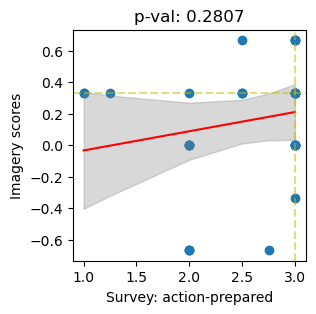

In [99]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_6_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6')

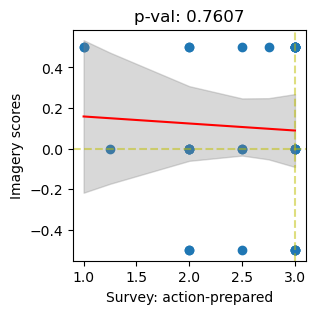

In [100]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_7_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q7')

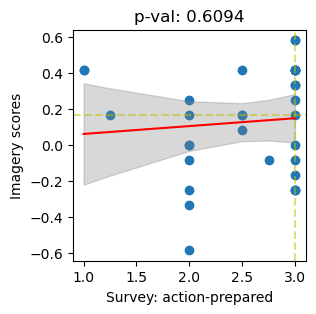

In [101]:
dispalay_regression_dicts(
    all_action_survey_scores,
    imagery_scores,
    'Survey: action-prepared', 
    'Imagery scores', 
    'reg_q1_vs_q6q7')

#### How about these question with gaze decoding accuracy?

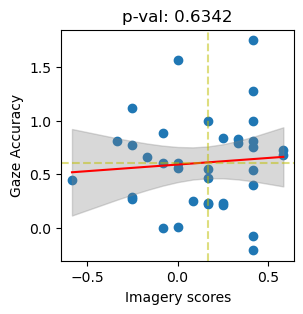

In [102]:
dispalay_regression_dicts(
    imagery_scores,
    acc_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_delay')

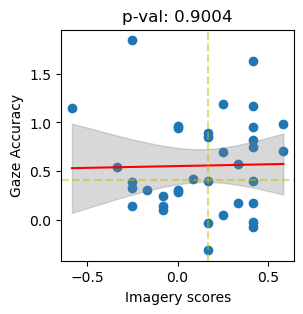

In [103]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi')

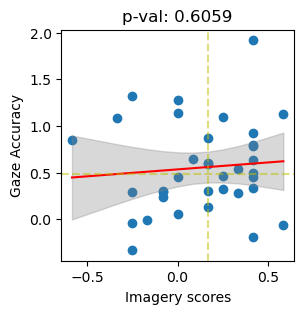

In [104]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc')

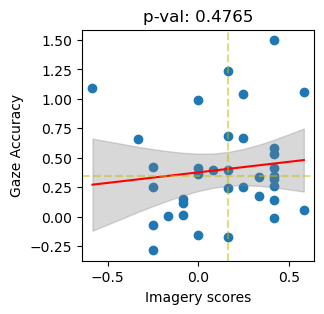

In [105]:
dispalay_regression_dicts(
    imagery_scores,
    acc_enc_isi,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_enc_isi')

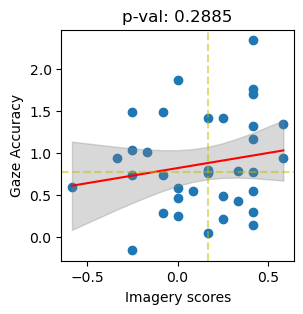

In [106]:
dispalay_regression_dicts(
    imagery_scores,
    acc_isi_delay,
    'Imagery scores',
    'Gaze Accuracy', 
    'reg_q6q7_vs_gaze_acc_isi_delay')